In [ ]:
%pip install kaggle
%pip install patchify

In [ ]:
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery
!unzip semantic-segmentation-of-aerial-imagery.zip

In [3]:
import os
import cv2
from pathlib import Path
from PIL import Image
import numpy as np
import random
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [8]:
dataset_root_folder = "."
dataset_name = "Semantic segmentation dataset"

In [9]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
  dir_name = path.split(os.path.sep)[-1]
  # print(dir_name)
  if dir_name == "masks": # 'images
    images = os.listdir(path)
    print(path)
    for i, image_name in enumerate(images):
      if image_name.endswith(".png"): # .jpg
        # print(image_name)
        a = True

.\Semantic segmentation dataset\Tile 1\masks
.\Semantic segmentation dataset\Tile 2\masks
.\Semantic segmentation dataset\Tile 3\masks
.\Semantic segmentation dataset\Tile 4\masks
.\Semantic segmentation dataset\Tile 5\masks
.\Semantic segmentation dataset\Tile 6\masks
.\Semantic segmentation dataset\Tile 7\masks
.\Semantic segmentation dataset\Tile 8\masks


In [10]:
image_patch_size = 256

In [11]:
image = cv2.imread(f"{dataset_root_folder}/{dataset_name}/Tile 1/images/image_part_001.jpg")
image.shape

(644, 797, 3)

In [12]:
(image.shape[1] // image_patch_size) * image_patch_size

768

In [13]:
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

image_patches.shape

(2, 3, 1, 256, 256, 3)

In [14]:
image_patches[0, 0, :, :].shape

(1, 256, 256, 3)

In [15]:
image_x = image_patches[0, 0, :, :]
image_x.reshape(-1, 3).shape

(65536, 3)

In [16]:
image_x.shape[-1]

3

In [17]:
image_x = image_patches[0, 0, :, :]
minmax_scaler = MinMaxScaler()
image_y = minmax_scaler.fit_transform(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape)
image_y.shape

(1, 256, 256, 3)

In [18]:
image_y[0].shape

(256, 256, 3)

In [19]:
minmax_scaler = MinMaxScaler()

image_dataset = []
mask_dataset = []

for image_type in ['images', 'masks']:
  image_extension = 'jpg' if image_type == 'images' else 'png'

  for title_id in range(1, 8):
    for image_id in range(1, 20):
      image_path = Path(f"{dataset_root_folder}/{dataset_name}/Tile {title_id}/{image_type}/image_part_{image_id:03}.{image_extension}")
      if image_path.is_file():

        image = cv2.imread(str(image_path)) # BGR
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # RGB

        # image_dataset.append(image)
        # print(image.shape)
        size_x = (image.shape[1] // image_patch_size) * image_patch_size
        size_y = (image.shape[0] // image_patch_size) * image_patch_size
        # print(f"shape: {image.shape} size_x: {size_x} size_y: {size_y}")
        image = Image.fromarray(image)
        image = image.crop((0, 0, size_x, size_y))
        # print(image.size)
        image = np.array(image)
        patches_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        # print(f"shape: {image.shape} patches_images: {patches_images.shape}")
        for i in range(patches_images.shape[0]):
          for j in range(patches_images.shape[1]):

            if image_type == 'images':
              image_x = patches_images[i, j, :, :]
              individual_patched_image = minmax_scaler.fit_transform(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape) # 3 -> RGB img.shape[-1]
              individual_patched_image = individual_patched_image[0]
              # print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)

            elif image_type == 'masks':
              image_x = patches_images[i, j, :, :]
              individual_patched_image = image_x[0]
              mask_dataset.append(individual_patched_image)

In [20]:
len(image_dataset), len(mask_dataset)

(945, 945)

## Plot the images vs Masks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


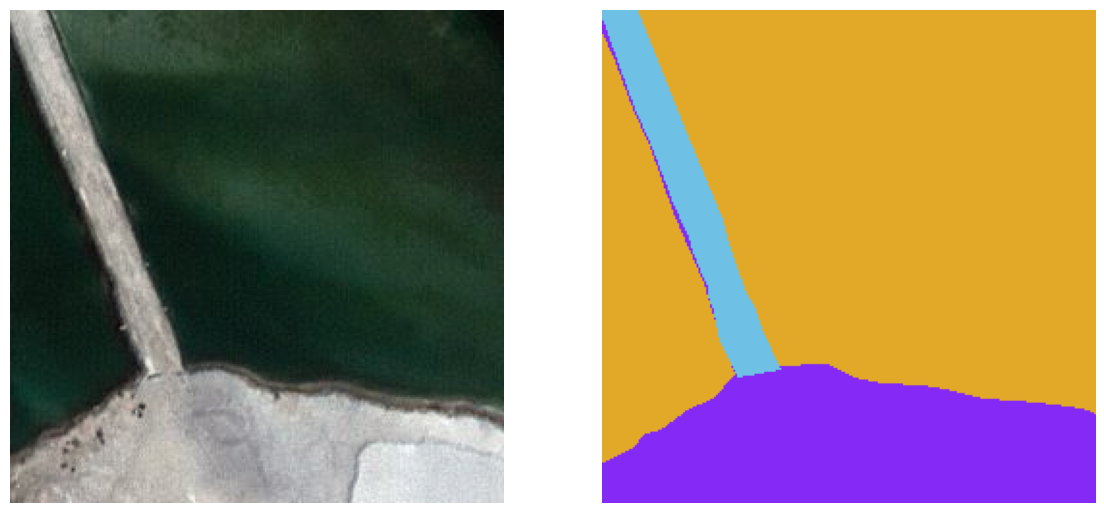

In [21]:
plt.figure(figsize=(14, 8))
rand_idx = random.randint(0, len(image_dataset))
plt.subplot(1, 2, 1)
plt.imshow((image_dataset[rand_idx]))
plt.axis("off");
plt.subplot(1, 2, 2)
plt.imshow(mask_dataset[rand_idx])
plt.axis("off");

## Encoding the masks -> labels

In [22]:
class_building = '#3C1098'
class_land = '#8429F6'
class_road = "#6EC1E4"
class_vegetation = "#FEDD3A"
class_water = "#E2A929"
class_unlabeled = '#9B9B9B'

def hex_to_array(hex_code):
  if hex_code.startswith('#'):
    hex_code = hex_code.lstrip('#')
  return np.array(tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4)))

In [23]:
class_building = hex_to_array(class_building)
class_land = hex_to_array(class_land)
class_road = hex_to_array(class_road)
class_vegetation = hex_to_array(class_vegetation)
class_water = hex_to_array(class_water)
class_unlabeled = hex_to_array(class_unlabeled)

In [32]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  # print(label_segment)
  label_segment = label_segment[:, :, 0]
  return label_segment

In [33]:
labels = []
for i in range(len(mask_dataset)):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [35]:
labels = np.expand_dims(labels, axis=3)
labels.shape

(945, 256, 256, 1)

In [37]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

## Plot the images vs Masks

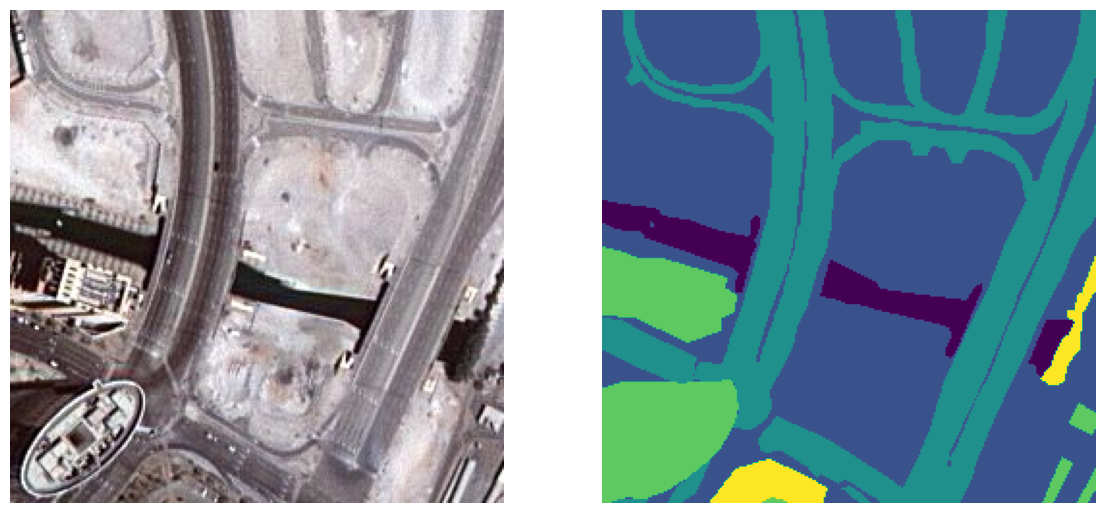

In [46]:
plt.figure(figsize=(14, 8))
rand_idx = random.randint(0, len(image_dataset))
plt.subplot(1, 2, 1)
plt.imshow((image_dataset[rand_idx]))
plt.axis("off");
plt.subplot(1, 2, 2)
plt.imshow(labels[rand_idx][:, :, 0])
plt.axis("off");

## Showing Masks vs Labels

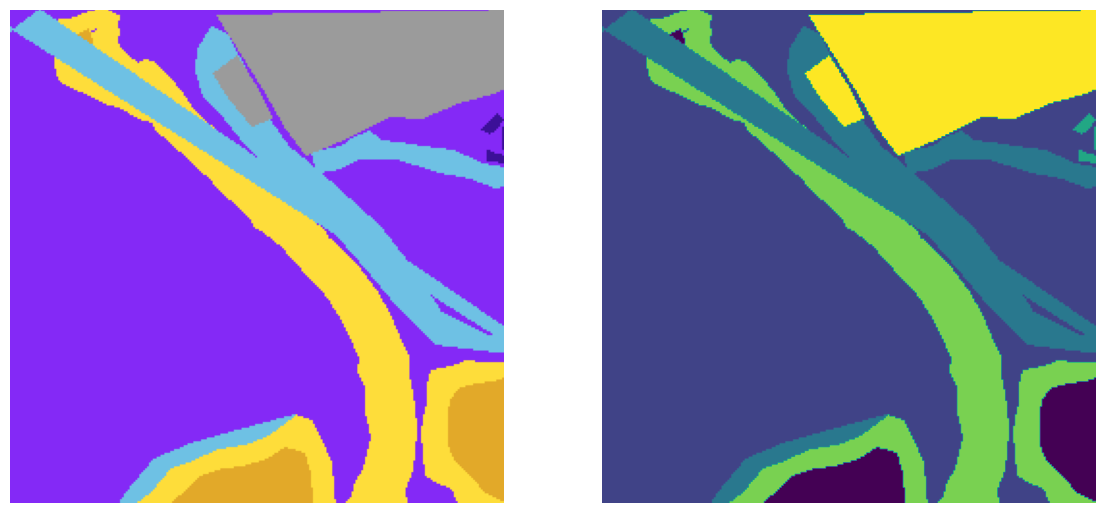

In [49]:
plt.figure(figsize=(14, 8))
rand_idx = random.randint(0, len(image_dataset))
plt.subplot(1, 2, 1)
plt.imshow((mask_dataset[rand_idx]))
plt.axis("off");
plt.subplot(1, 2, 2)
plt.imshow(labels[rand_idx][:, :, 0])
plt.axis("off");

# Train Test Split

In [63]:
master_training_dataset = np.array(image_dataset)
total_classes = len(np.unique(labels))
total_classes

6

In [54]:
from tensorflow.keras.utils import to_categorical
labels_catagorical_dataset = to_categorical(labels, num_classes=total_classes)

In [64]:
labels_catagorical_dataset.shape, master_training_dataset.shape

((945, 256, 256, 6), (945, 256, 256, 3))

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, labels_catagorical_dataset, test_size=0.15, random_state=42)

In [66]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [67]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
image_height, image_width, image_channels

(256, 256, 3)